# iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 feature 사용 
- 구현 프레임 워크 : pytorch

## [1] 모듈 로딩 및 데이터 준비

In [19]:
# 모듈 로딩 

import torch                    # 텐서 및 수치 계산 함수 관련 모듈 
import torch.nn as nn           # 인공신경망 관련 모듈 
import torch.nn.functional as F    # 손실, 거래 등 함수 관련 모듈 
import torch.optim as optimizer # 최적화 기법 관련 모듈 

import pandas as pd             # 데이터 파일 분석 과련 모듈 
import matplotlib.pyplot as plt

In [20]:
torch.manual_seed(1)

In [21]:
# 데이터 로딩 : csv -> DF 

DATA_FILE = '../DATA/iris.csv'

iris_df = pd.read_csv(DATA_FILE, usecols=[2,3])
iris_df.head(2)


,petal.length,petal.width
0,1.4,0.2
1,1.4,0.2


# [2] 모델 준비 
- 학습 방법 : 지도학습 - 회귀 
- 알고리즘 : 선형관계 -> 선형모델 -> nn.Linear

In [22]:
# in_features : petal.length 1개 
# out_feature : petal.width 1개

model = nn.Linear(1,1)

In [23]:
# 가중치와 절편 확인 
for name, param in model.named_parameters():

    print(f'[{name}] {param}\n')

[weight] Parameter containing:
tensor([[0.5153]], requires_grad=True)

[bias] Parameter containing:
tensor([-0.4414], requires_grad=True)



## [3] 최적화 인스턴스 준비 

In [24]:
# 모델의 가중치와 절편 최적화 ==> 인스턴스에 전달 
adam_optim = optimizer.Adam(model.parameters(), lr = 0.1)

# [4] 학습 ==> 개발자가 구현 

### [4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행하거나 또는 학습 전 진행 

In [25]:
feature_ts = torch.from_numpy(iris_df[iris_df.columns[:-1]].values).float()
feature_ts.shape

torch.Size([150, 1])

In [26]:
target_ts = torch.from_numpy(iris_df[['petal.width']].values).float()
target_ts.shape

torch.Size([150, 1])

In [27]:
from sklearn.model_selection import train_test_split

# train, test 쪼개기 
x_train, x_test, y_train, y_test = train_test_split(feature_ts, target_ts, test_size=0.2)

# train, valid 쪼개기 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

print(f'[Feature] Train {x_train.shape}, Test {x_test.shape}, Val {x_val.shape}')
print(f'[Target] Train {y_train.shape}, Test {y_test.shape}, Val {y_val.shape}')

[Feature] Train torch.Size([96, 1]), Test torch.Size([30, 1]), Val torch.Size([24, 1])
[Target] Train torch.Size([96, 1]), Test torch.Size([30, 1]), Val torch.Size([24, 1])


### [4-2] 학습 진행 
- 학습 횟수 결정 => 에포크 설정 
- 학습 결과 저장 => 손실저장 변수

In [28]:
EPOCH = 10
#loss_history = [] # 시각화 하기 위해 리스트에 담음 

In [29]:
# 테스트/검증 함수 
# => 가중치, 절편 업데이트 x, 최적화 미진행 
# => 현재 가중치와 절편값으로 테스트 진행 

# 모델 학습 함수 
def testing(test_ts, target_ts, kind='Val'):

    with torch.no_grad():
        # -(1) 학습 진행 - forward 
        pre_y = model(test_ts)
        print(f'{pre_y.shape}')

        # -(2) 오차계산 - 손실함수 
        loss = F.mse_loss(pre_y, target_ts)
        # loss_history.append(loss.item()) # tensor로 들어가서 item으로 뺌 

        # # -(3) 최적화 - 가중치, 절편 업데이트 backward 
        # # => 업데이트 안 하므로 필요 x 
        # adam_optim.zero_grad()
        # loss.backward()
        # adam_optim.step()

        # -(4) 학습 결과 출력 및 저장 
        print(f'[{kind}] LOSS : {loss}')

    return loss

In [30]:
# 모델 학습 함수 
def training2(feature_ts, target_ts, val_ts, val_target_ts):

    loss_history = [[],[]]

    for epoch in range(EPOCH):
        # -(1) 학습 진행 - forward 
        pre_y = model(feature_ts)
        print(f'{pre_y.shape}')

        # -(2) 오차계산 - 손실함수 
        loss = F.mse_loss(pre_y, target_ts)
        loss_history[0].append(loss.item()) # tensor로 들어가서 item으로 뺌 

        # -(3) 최적화 - 가중치, 절편 업데이트 backward 
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()

        # -(4) 검증 - 모델이 제대로 만들어지는 검사용 
        val_loss = testing(val_ts, val_target_ts)
        loss_history[1].append(val_loss.item())

        # -(4) 학습 결과 출력 및 저장 
        print(f'[{epoch}/{EPOCH}] LOSS : {loss}')

    return loss_history

In [31]:
# 모델 학습 함수 
def training_dict(feature_ts, target_ts, val_ts, val_target_ts):

    loss_history = {} # dict 지정 

    for epoch in range(EPOCH):
        # -(1) 학습 진행 - forward 
        pre_y = model(feature_ts)
        print(f'{pre_y.shape}')

        # -(2) 오차계산 - 손실함수 
        loss = F.mse_loss(pre_y, target_ts)
        # loss_history.append(loss.item()) # tensor로 들어가서 item으로 뺌 

        # -(3) 최적화 - 가중치, 절편 업데이트 backward 
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()

        # -(4) 검증 - 모델이 제대로 만들어지는 검사용 
        val_loss = testing(val_ts, val_target_ts)
        # loss_history[1].append(val_loss.item())

        loss_history[loss.item()] = val_loss.item()

        # -(4) 학습 결과 출력 및 저장 
        print(f'[{epoch}/{EPOCH}] LOSS : {loss}')

    return loss_history

In [32]:
loss = training2(x_train, y_train, x_val, y_val)

torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.04355243965983391
[0/10] LOSS : 0.14918164908885956
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.07167085260152817
[1/10] LOSS : 0.0867181122303009
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.033263836055994034
[2/10] LOSS : 0.13078612089157104
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.0371440090239048
[3/10] LOSS : 0.06942284107208252
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.07858525216579437
[4/10] LOSS : 0.050976961851119995
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.08469080179929733
[5/10] LOSS : 0.08359140902757645
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.053914088755846024
[6/10] LOSS : 0.08871480822563171
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.02831757627427578
[7/10] LOSS : 0.06185994669795036
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.026896506547927856
[8/10] LOSS : 0.04652133584022522
torch.Size([96, 1])
torch.Size([24,

In [33]:
loss_dict = training_dict(x_train, y_train, x_val, y_val)

torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.02933955006301403
[0/10] LOSS : 0.07133997976779938
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.024548562243580818
[1/10] LOSS : 0.06474398821592331
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.03145870566368103
[2/10] LOSS : 0.049709901213645935
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.047070011496543884
[3/10] LOSS : 0.0459306426346302
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.05516619607806206
[4/10] LOSS : 0.05464957654476166
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.04804075136780739
[5/10] LOSS : 0.06037347391247749
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.034304335713386536
[6/10] LOSS : 0.0548635870218277
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.02586236037313938
[7/10] LOSS : 0.04644258692860603
torch.Size([96, 1])
torch.Size([24, 1])
[Val] LOSS : 0.024869734421372414
[8/10] LOSS : 0.04572482407093048
torch.Size([96, 1])
torch.Size([24

In [35]:
loss_dict

{0.07133997976779938: 0.02933955006301403,
 0.06474398821592331: 0.024548562243580818,
 0.049709901213645935: 0.03145870566368103,
 0.0459306426346302: 0.047070011496543884,
 0.05464957654476166: 0.05516619607806206,
 0.06037347391247749: 0.04804075136780739,
 0.0548635870218277: 0.034304335713386536,
 0.04644258692860603: 0.02586236037313938,
 0.04572482407093048: 0.024869734421372414,
 0.05145608261227608: 0.02545243687927723}

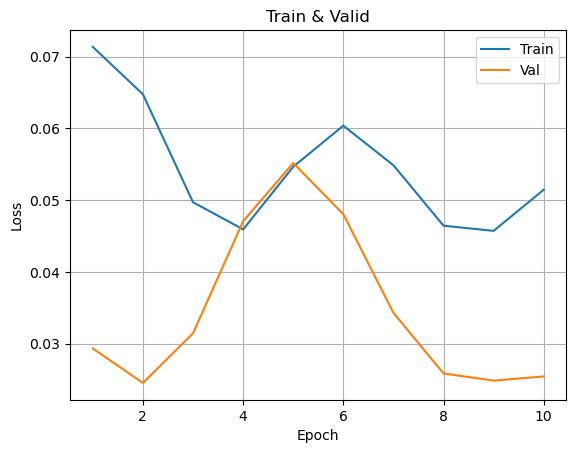

In [38]:
# 학습 후 loss 시각화 

plt.plot(range(1,11), loss_dict.keys(), label = 'Train')
plt.plot(range(1,11), loss_dict.values(), label = 'Val')
plt.title('Train & Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

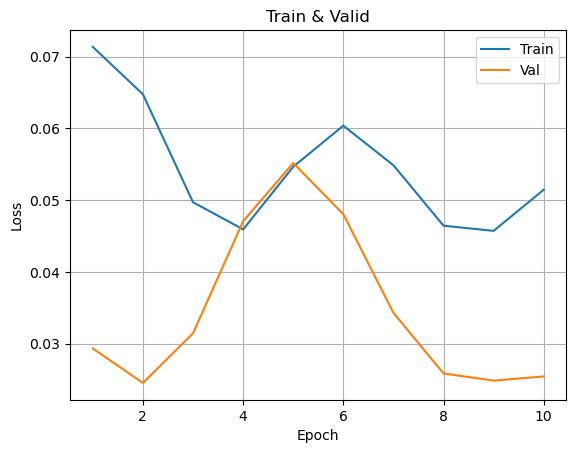

In [34]:
# 학습 후 loss 시각화 

plt.plot(range(1,11), loss[0], label = 'Train')
plt.plot(range(1,11), loss[1], label = 'Val')
plt.title('Train & Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()